<a href="https://colab.research.google.com/github/lblogan14/hands_on_notes/blob/master/Ch3_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MNIST

Use **fetch_mldata** to download the MNIST dataset

In [64]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [0]:
X, y = mnist['data'], mnist['target']

In [66]:
X.shape

(70000, 784)

In [67]:
y.shape

(70000,)

Plot an example,

5.0

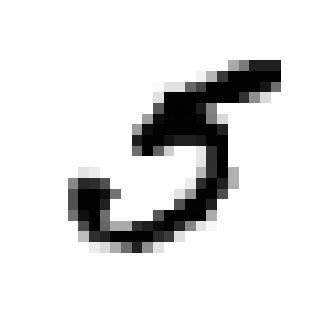

In [68]:
import matplotlib.pyplot as plt
eg = 36000
some_digit = X[eg]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=plt.cm.binary, interpolation='nearest')
plt.axis('off')
y[eg]

Split dataset into training set and testing set

In [0]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Shuffle the training set before using,

In [0]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

#Training a Binary Classifier
simplify the problem for now and only try to identify one digit—for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5.

In [0]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

Use a *Stochastic Gradient Descent (SGD)* classifier, using Scikit-Learn’s **SGDClassifier** class. This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for *online learning*)

In [72]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=1)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([ True])

#Performance Measures
##Measuring Accuracy Using Cross-Validation
Use the **cross_val_score()** function to evaluate your **SGDClassifier** model using K-fold cross-validation, with three folds.

In [73]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/s

array([0.93925, 0.9612 , 0.96965])

In [74]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    pass
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)
  
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90845, 0.9127 , 0.9078 ])

This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about
90% of the time.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with *skewed datasets* (i.e., when some classes are much more frequent than others).

###Implementing Cross-Validation
The **StratifiedKFold** class performs stratified sampling (as explained in Chapter 2) to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

In [75]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = (y_train_5[train_index])
  X_test_fold = X_train[test_index]
  y_test_fold = (y_train_5[test_index])

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred)) #

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.93925


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.9612


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.96965


##Confusion Matrix
The general idea is to count the number of times instances of class A are classified as class B.

Do not use the test set for now. (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch).
Instead, use **cross_val_predict()**

In [76]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/s

Just like the **cross_val_score()** function, **cross_val_predict()** performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predic‐ tions made on each test fold. This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).

Confusion Matrix,

In [77]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53242,  1337],
       [ 1261,  4160]])

Each row in a confusion matrix represents an *actual* class, while each column represents a *predicted* class. 

The first row of this matrix considers non-5 images (the *negative class*): 53,384 of them were correctly classified as non-5s (they are called ***true negatives***), while the remaining 1,195 were wrongly classified as 5s (***false positives***). 

The second row considers the images of 5s (the *positive class*): 1,165 were wrongly classified as non-5s (***false negatives***), while the remaining 4,256 were correctly classified as 5s (***true positives***).

Confusion matrix,

True Negative | False Negative
--- | ---
False Positive | True Positive

*Precision* is the accuracy of the positive predictions,

$precision = \dfrac{TruePositive}{TruePositive + False Positive}$

*Recall*, also called *sensitivity* or *true positive rate*, is the ratio of positive instances that are correctly detected

$recall = \dfrac{TruePositive}{TruePositive + False Negative}$

 |  | recall
--- | --- | ---
 | True Negative | False Negative
precision | False Positive | True Positive

##Precision and Recall

In [78]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.7567764235037293

In [79]:
recall_score(y_train_5, y_train_pred)

0.7673860911270983

The *F1 score* is the *harmonic mean* of precision and recall.

Whereas the regular mean treats all values equally, the *harmonic mean* gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.

$F_1 = \dfrac{2}{\dfrac{1}{precision} + \dfrac{1}{recall}} =2 \times \dfrac{precision \times recall}{precision + recall} = \dfrac{TruePos}{TruePos + \dfrac{FalseNeg+FalsePos}{2}}$

In [80]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7620443304634548

##Precision/Recall Trade-off
Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifier’s **predict()** method, you can call its **decision_function()** method, which returns a score for each instance, and then make predictions based on those scores using any threshold you want:

In [81]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([129735.63546238])

In [82]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [83]:
threshold = 30000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

This confirms that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 300,000.

Use **cross_val_predict()** to get the scores first

In [84]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/s

Compute compute precision and recall for all possible thresholds using the **precision_recall_curve()** function:

In [85]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
print(precisions.shape)
print(recalls.shape)
print(thresholds.shape)

(59768,)
(59768,)
(59767,)


Plot precision and recall as a function of the threshold

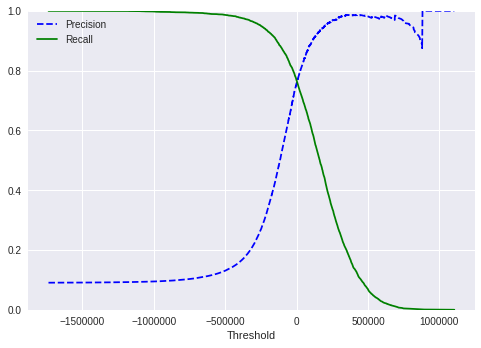

In [86]:
def plot_precision_recall_vs_threshold(precisions, recalls, threshold):
  plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
  plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
  plt.xlabel('Threshold')
  plt.legend(loc='upper left')
  plt.ylim([0,1])
  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

Select the threshold value that gives you the best precision/recall tradeoff for the specific task.

Another way is to plot precision against recall,

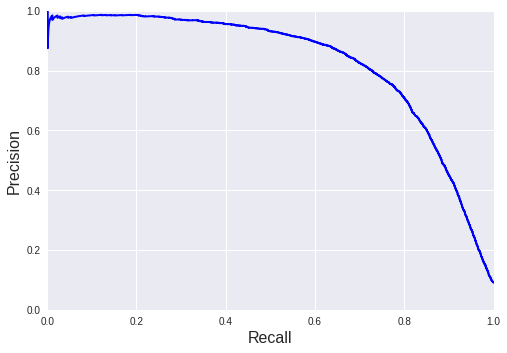

In [87]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plot_precision_vs_recall(precisions, recalls)

Suppose aiming for 90% precision, then in the first plot the threshold is about 96,000. To make predictions (on the training set for now), 

In [88]:
y_train_pred_90 = (y_scores > 96000)
precision_score(y_train_5, y_train_pred_90)

0.8862259678693706

In [89]:
recall_score(y_train_5, y_train_pred_90)

0.620734181885261

##The ROC Curve
The *receiver operating characteristic* (ROC) curve plots the *true positive rate* (another name for recall) against the *false positive rate*.

The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the *true negative rate*,
which is the ratio of negative instances that are correctly classified as negative. 

The TNR is also called *specificity*. Hence the ROC curve plots *sensitivity* (recall) versus 1 – *specificity*.

 | specificity` | recall
--- | --- | ---
 | True Negative | False Negative
precision | False Positive | True Positive

In [0]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

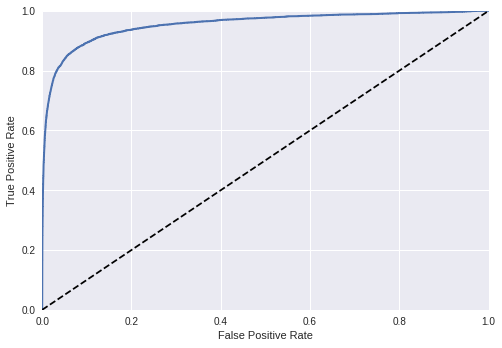

In [91]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--')
  plt.axis([0,1,0,1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  
plot_roc_curve(fpr, tpr)

The higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

Use the *area under the curve* (AUC) to compare classifier.

A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [92]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9548866781615404

Train a **RandomForestClassifier** and compare its ROC curve and ROC AUC score to the **SGDClassifier**.

In [0]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=1)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
method="predict_proba")

Need scores, not probabilities to plot a ROC curve,

In [0]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

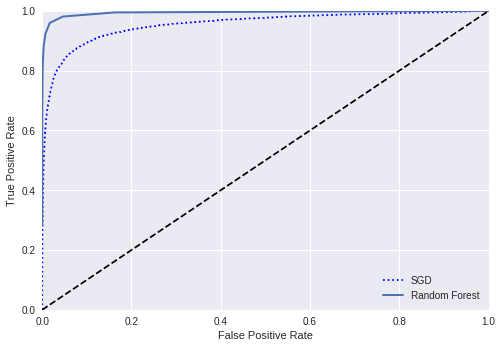

In [95]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')

In [96]:
roc_auc_score(y_train_5, y_scores_forest)

0.9938414100501899

#Multiclass Classification
* *One-versus-all* (OvA) - classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit

* *One_versus-one* (OvO) - train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. For the MNIST problem, this means training 45 binary classifiers!

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set, so for these algorithms OvO is preferred since it is faster to train many classifiers on small training sets than training few classifiers on large training sets. For most binary classification algorithms, however, OvA is preferred.

For example, **SGDClassifier** automatically runs OvA

In [97]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([5.])

**SGDClassifier** actually trained 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score.

In [98]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-166594.74646686, -408551.89977682, -342870.76615027,
        -189118.89565366, -331770.60897202,  129735.63546238,
        -636731.62264858, -202002.67987318, -713026.35042684,
        -479731.47875232]])

In [99]:
np.argmax(some_digit_scores)

5

In [100]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [101]:
sgd_clf.classes_[5]

5.0

Use **OneUsOneClassifier** or **OneVsRestClassifier** to force the classifier to use this strategy.

In [102]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=1))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/s

array([5.])

In [103]:
len(ovo_clf.estimators_) # number of classifier created

45

In [104]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/s

array([0.87797441, 0.87849392, 0.8693304 ])

Scaling the inputs to increase accuracy

In [105]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/s

array([0.90986803, 0.90929546, 0.9106866 ])

Random Forest classifiers don't run OvA or OvO because it can directly classify instances into multiple classes. 

Use **predict_proba()** to get a list of probabilities that the classifier assigned to each instance for each class:

In [106]:
forest_clf.fit(X_train, y_train)
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.1, 0. , 0.9, 0. , 0. , 0. , 0. ]])

#Error Analysis
First, look at the confusion matrix. Use the **cross_val_predict()** function, then call the **confusion_matrix()** function,

In [107]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/s

array([[5729,    3,   27,    8,   12,   52,   41,    9,   40,    2],
       [   1, 6481,   45,   26,    5,   44,    6,   14,  110,   10],
       [  58,   40, 5330,   88,   90,   24,   99,   63,  150,   16],
       [  53,   45,  134, 5324,    2,  254,   41,   55,  128,   95],
       [  22,   28,   36,    8, 5360,    9,   59,   28,   93,  199],
       [  72,   42,   36,  165,   75, 4635,  112,   29,  163,   92],
       [  29,   26,   46,    2,   45,  101, 5620,    4,   44,    1],
       [  23,   19,   73,   31,   55,   10,    7, 5801,   19,  227],
       [  52,  153,   74,  156,   14,  163,   61,   27, 5022,  129],
       [  39,   34,   26,   89,  147,   34,    3,  199,   83, 5295]])

Use **matshow()** to see the confusion matrix

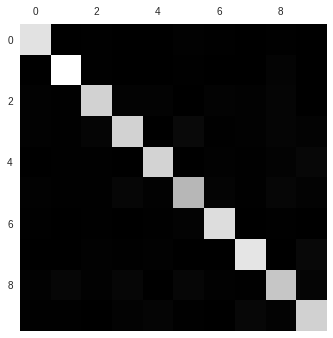

In [108]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.grid(False)

Divide each value in the confusion matrix by the number of images in the corresponding class, so we can compare error rates instead of absolute number of errors

In [109]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
row_sums

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]])

In [0]:
norm_conf_mx = conf_mx / row_sums

Now fill the diagonal with zeros to keep only the errors,

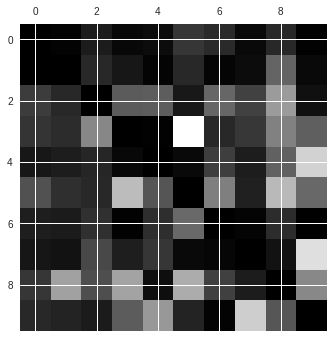

In [111]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

Analyzing the confusion matrix can often give you insights on ways to improve your classifier. Looking at this plot, it seems that your efforts should be spent on improving classification of 8s and 9s, as well as fixing the specific 3/5 confusion.

In [0]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [0]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

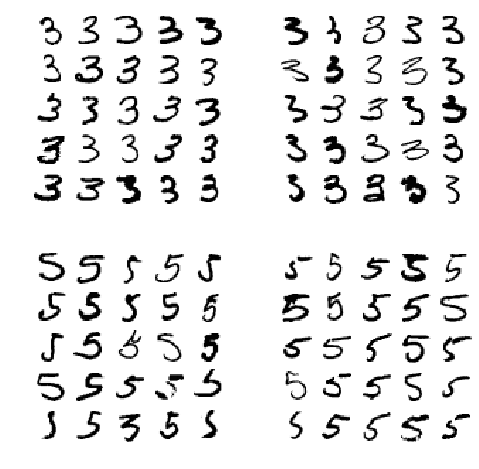

In [114]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

#Multilabel Classification

In [115]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train %2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
y_multilabel

array([[False,  True],
       [False, False],
       [ True,  True],
       ...,
       [False, False],
       [False, False],
       [False,  True]])

In [116]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [106]:
knn_clf.predict([some_digit])

array([[False,  True]])

Compute the average $F_1$ score aross all labels.

In [0]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average='marco')

This assumes that all labels are equally important, which may not be the case.

#Multioutput Classification
a generalization of multilabel classification where each label can be multiclass.

To illustrate this, let’s build a system that removes noise from images. It will take as input a noisy digit image, and it will (hopefully) output a clean digit image, represented as an array of pixel intensities, just like the MNIST images.

The classifier’s output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255).

Creat the training and test sets by taking the MNIST images and adding noise to their pixel intensities using NumPy’s **randint()** function. The target images will be the original images:

In [59]:
noise = np.random.randint(0,100, (len(X_train), 784)) # randint(low, high, size)
X_train_mod = X_train + noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

(60000, 784)

Look at an example image from testing set,

Text(0.5,1,'Clean Target Image')

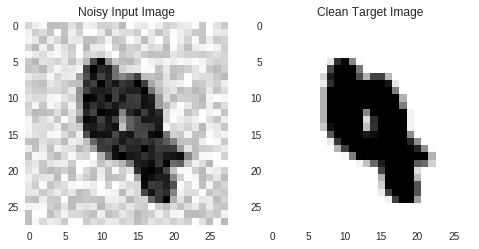

In [63]:
some_index = 5000
plt.subplot(121)
plt.imshow(X_test_mod[some_index].reshape(28,28), cmap=plt.cm.binary, interpolation='nearest')
plt.grid(False)
plt.title('Noisy Input Image')
plt.subplot(122)
plt.imshow(y_test_mod[some_index].reshape(28,28), cmap=plt.cm.binary, interpolation='nearest')
plt.grid(False)
plt.title('Clean Target Image')

Train the classifier,

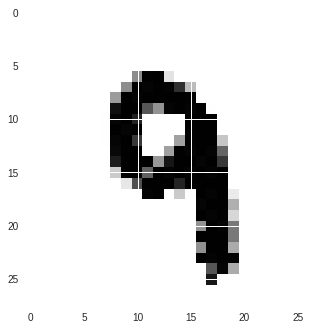

In [61]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plt.imshow(clean_digit.reshape(28,28), cmap=plt.cm.binary, interpolation='nearest')